## Predicting Crime in Berkeley

**GOAL**: Examine robbery, assault, sexual assault during the hours of 8pm-12am in areas around the UC Berkeley campus

In [605]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
%matplotlib inline
import seaborn as sns
import sklearn

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from collections import OrderedDict

cmaps = OrderedDict()

# import pymc3 as pm # CAN'T USE PyMC3!
# import theano.tensor as tt

In [487]:
bpd = pd.read_csv('berkeleypd.csv')
bpd.head(5)

,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State
0,19091845,THEFT FELONY (OVER $950),9/1/19 0:00,11:00,LARCENY,0,11/8/19 7:01,"BOLIVAR DR\nBerkeley, CA",BOLIVAR DR,Berkeley,CA
1,19092225,VANDALISM,10/11/19 0:00,5:00,VANDALISM,5,11/8/19 7:01,"HEARST AVE\nBerkeley, CA",HEARST AVE,Berkeley,CA
2,19051156,VEHICLE STOLEN,9/10/19 0:00,19:00,MOTOR VEHICLE THEFT,2,11/8/19 7:01,"100 MENLO PL\nBerkeley, CA",100 MENLO PL,Berkeley,CA
3,19091890,BURGLARY AUTO,9/8/19 0:00,2:00,BURGLARY - VEHICLE,0,11/8/19 7:01,"HASTE ST\nBerkeley, CA",HASTE ST,Berkeley,CA
4,19041310,VANDALISM,7/29/19 0:00,0:30,VANDALISM,1,11/8/19 7:01,"6000 CHABOLYN TE\nBerkeley, CA",6000 CHABOLYN TE,Berkeley,CA


### Clean the data

In [488]:
""" convert date to datetime object, time as time """
bpd['EVENTDT'] = pd.to_datetime(bpd['EVENTDT'], format='%m/%d/%y %H:%M')
bpd['EVENTTM'] = pd.to_datetime(bpd['EVENTTM'], format='%H:%M')

In [489]:
count = 0
for i in bpd.index:
    if '(' not in bpd.loc[i,'Block_Location']:
        bpd = bpd.drop(i)
        
for i in bpd.index:
    bpd.loc[i,'LatLon'] = bpd.loc[i,'Block_Location'][bpd.loc[i,'Block_Location'].find("(")+1:bpd.loc[i,'Block_Location'].rfind(")")]
    bpd.loc[i,'Lat'] = float(bpd.loc[i,'LatLon'][0:bpd.loc[i,'LatLon'].find(',')])
    bpd.loc[i,'Lon'] = float(bpd.loc[i,'LatLon'][bpd.loc[i,'LatLon'].find(',')+2:])

In [490]:
bpd[bpd['City'] != 'Berkeley']

,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State,LatLon,Lat,Lon


In [491]:
""" remove unneeded columns """
bpd = bpd.drop(['CASENO', 'State', 'Block_Location', 'BLKADDR', 'City'], axis=1) 
bpd.head()

,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,LatLon,Lat,Lon
7,NARCOTICS,2019-10-02,1900-01-01 14:48:00,DRUG VIOLATION,3,11/8/19 7:01,"37.866025, -122.258623",37.866025,-122.258623
8,ALCOHOL OFFENSE,2019-05-20,1900-01-01 13:50:00,LIQUOR LAW VIOLATION,1,11/8/19 7:01,"37.873687, -122.268616",37.873687,-122.268616
9,BURGLARY AUTO,2019-10-19,1900-01-01 21:41:00,BURGLARY - VEHICLE,6,11/8/19 7:01,"37.850385, -122.270897",37.850385,-122.270897
10,BURGLARY AUTO,2019-09-10,1900-01-01 15:00:00,BURGLARY - VEHICLE,2,11/8/19 7:01,"37.868663, -122.301325",37.868663,-122.301325
11,DISTURBANCE,2019-05-24,1900-01-01 01:25:00,DISORDERLY CONDUCT,5,11/8/19 7:01,"37.856111, -122.260248",37.856111,-122.260248


### insert map of crimes here

# change detection
(Can't run PyMC3 on IBM Z... Need help from IBM engineers...)

In [492]:
bpd['EVENTDT'] = pd.to_datetime(bpd['EVENTDT'], format='%m/%d/%y %H:%M')
bpd['EVENTTM'] = pd.to_datetime(bpd['EVENTTM'], format='%H:%M')
bpd.head()

,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,LatLon,Lat,Lon
7,NARCOTICS,2019-10-02,1900-01-01 14:48:00,DRUG VIOLATION,3,11/8/19 7:01,"37.866025, -122.258623",37.866025,-122.258623
8,ALCOHOL OFFENSE,2019-05-20,1900-01-01 13:50:00,LIQUOR LAW VIOLATION,1,11/8/19 7:01,"37.873687, -122.268616",37.873687,-122.268616
9,BURGLARY AUTO,2019-10-19,1900-01-01 21:41:00,BURGLARY - VEHICLE,6,11/8/19 7:01,"37.850385, -122.270897",37.850385,-122.270897
10,BURGLARY AUTO,2019-09-10,1900-01-01 15:00:00,BURGLARY - VEHICLE,2,11/8/19 7:01,"37.868663, -122.301325",37.868663,-122.301325
11,DISTURBANCE,2019-05-24,1900-01-01 01:25:00,DISORDERLY CONDUCT,5,11/8/19 7:01,"37.856111, -122.260248",37.856111,-122.260248


In [493]:
# Round time to the nearest hour
def timeround(tm):
    tm = tm - datetime.timedelta(minutes=tm.minute % 60, seconds=tm.second) 
    return tm

bpd['TIME_1HR'] = bpd['EVENTTM'].apply(timeround)
# bpd['TIME_1HR'] = [timeround(bpd['EVENTTM'][i]) for i in range(len(bpd['EVENTTM']))]

# Time only 
bpd['TIME_1HR'] = bpd['TIME_1HR'].apply(lambda x: x.time())

# Date only, don't think you need to run this
# bpd['EVENTDT'] = bpd['EVENTDT'].apply(lambda x: x)
bpd.head()


,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,LatLon,Lat,Lon,TIME_1HR
7,NARCOTICS,2019-10-02,1900-01-01 14:48:00,DRUG VIOLATION,3,11/8/19 7:01,"37.866025, -122.258623",37.866025,-122.258623,14:00:00
8,ALCOHOL OFFENSE,2019-05-20,1900-01-01 13:50:00,LIQUOR LAW VIOLATION,1,11/8/19 7:01,"37.873687, -122.268616",37.873687,-122.268616,13:00:00
9,BURGLARY AUTO,2019-10-19,1900-01-01 21:41:00,BURGLARY - VEHICLE,6,11/8/19 7:01,"37.850385, -122.270897",37.850385,-122.270897,21:00:00
10,BURGLARY AUTO,2019-09-10,1900-01-01 15:00:00,BURGLARY - VEHICLE,2,11/8/19 7:01,"37.868663, -122.301325",37.868663,-122.301325,15:00:00
11,DISTURBANCE,2019-05-24,1900-01-01 01:25:00,DISORDERLY CONDUCT,5,11/8/19 7:01,"37.856111, -122.260248",37.856111,-122.260248,01:00:00


# Lambda analysis

In [122]:
# Total number of police calls during each one-hour window
n_days = bpd.groupby('TIME_1HR')['EVENTDT'].nunique()
# Total number of days where at least a call happened during a given one-hour window
n_calls = bpd.groupby('TIME_1HR')['EVENTDT'].count()
# Average number of calls during each hour of the day
mean_calls = n_calls/n_days
mean_calls = pd.DataFrame({'time':mean_calls.index, 'ave_calls':mean_calls.values})

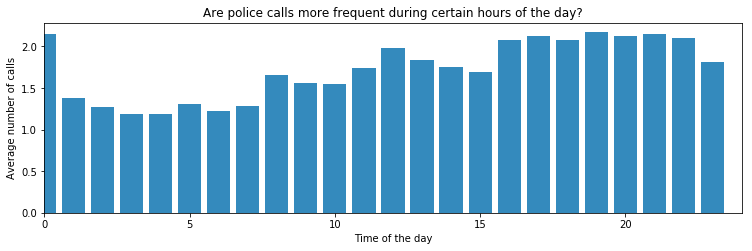

In [88]:
# Plot out 
plt.figure(figsize=(12.5, 3.5))
n_mean_calls = len(mean_calls)
plt.bar(np.arange(n_mean_calls), mean_calls['ave_calls'], color="#348ABD")
plt.xlabel("Time of the day")
plt.ylabel("Average number of calls")
plt.title("Are police calls more frequent during certain hours of the day?")
plt.xlim(0, n_mean_calls);

In [ ]:
with pm.Model() as model:
    alpha = 1.0/mean_calls['ave_calls'].mean()  # Recall count_data is the
                                   # variable that holds our txt counts
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_mean_calls - 1)

In [ ]:
with model:
    idx = np.arange(n_mean_calls) # Index
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)

In [ ]:
with model:
    observation = pm.Poisson("obs", lambda_, observed=mean_calls['ave_calls'])

In [ ]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000,step=step)

In [ ]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

In [ ]:
plt.figure(figsize=(12.5, 10))
#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)
plt.hist(lambda_1_samples, histtype='stepfilled', bins=100, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([0, 5])
plt.ylim([0, 2])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=100, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim([0, 5])
plt.ylim([0, 2])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
# divide each tau value by the # of samples to get the probability of that value 
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples) 
plt.hist(tau_samples, bins=n_mean_calls, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.) 
plt.xticks(np.arange(n_mean_calls))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([0, 24])
plt.xlabel(r"$\tau$ (in hour)")
plt.ylabel("probability");

## Distribution of crimes over 24 hrs
First, convert datetime to hours in [0, 23] (int).

In [494]:
bpd['Hour'] = bpd['TIME_1HR'].apply(lambda x: x.hour)
bpd.head()

,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,LatLon,Lat,Lon,TIME_1HR,Hour
7,NARCOTICS,2019-10-02,1900-01-01 14:48:00,DRUG VIOLATION,3,11/8/19 7:01,"37.866025, -122.258623",37.866025,-122.258623,14:00:00,14
8,ALCOHOL OFFENSE,2019-05-20,1900-01-01 13:50:00,LIQUOR LAW VIOLATION,1,11/8/19 7:01,"37.873687, -122.268616",37.873687,-122.268616,13:00:00,13
9,BURGLARY AUTO,2019-10-19,1900-01-01 21:41:00,BURGLARY - VEHICLE,6,11/8/19 7:01,"37.850385, -122.270897",37.850385,-122.270897,21:00:00,21
10,BURGLARY AUTO,2019-09-10,1900-01-01 15:00:00,BURGLARY - VEHICLE,2,11/8/19 7:01,"37.868663, -122.301325",37.868663,-122.301325,15:00:00,15
11,DISTURBANCE,2019-05-24,1900-01-01 01:25:00,DISORDERLY CONDUCT,5,11/8/19 7:01,"37.856111, -122.260248",37.856111,-122.260248,01:00:00,1


In [495]:
crimes = np.array(bpd.groupby('CVLEGEND').count().index)
crimes

array(['ALL OTHER OFFENSES', 'ARSON', 'ASSAULT', 'BURGLARY - COMMERCIAL',
       'BURGLARY - RESIDENTIAL', 'BURGLARY - VEHICLE',
       'DISORDERLY CONDUCT', 'DRUG VIOLATION', 'DUI', 'FAMILY OFFENSE',
       'FRAUD', 'KIDNAPPING', 'LARCENY', 'LARCENY - FROM VEHICLE',
       'LIQUOR LAW VIOLATION', 'MISSING PERSON', 'MOTOR VEHICLE THEFT',
       'NOISE VIOLATION', 'RECOVERED VEHICLE', 'ROBBERY', 'SEX CRIME',
       'VANDALISM', 'WEAPONS OFFENSE'], dtype=object)

In [496]:
offense = np.array(bpd.groupby('OFFENSE').count().index)
offense

array(['2ND RESPONSE', 'ALCOHOL OFFENSE', 'ARSON', 'ASSAULT/BATTERY FEL.',
       'ASSAULT/BATTERY MISD.', 'BRANDISHING', 'BURGLARY AUTO',
       'BURGLARY COMMERCIAL', 'BURGLARY RESIDENTIAL', 'DISTURBANCE',
       'DISTURBANCE - NOISE', 'DOMESTIC VIOLENCE', 'FRAUD/FORGERY',
       'GUN/WEAPON', 'IDENTITY THEFT', 'KIDNAPPING', 'MISSING ADULT',
       'MISSING JUVENILE', 'MUNICIPAL CODE', 'NARCOTICS', 'ROBBERY',
       'SEXUAL ASSAULT FEL.', 'SEXUAL ASSAULT MISD.',
       'THEFT FELONY (OVER $950)', 'THEFT FROM AUTO', 'THEFT FROM PERSON',
       'THEFT MISD. (UNDER $950)', 'VANDALISM', 'VEHICLE CODE - DUI',
       'VEHICLE RECOVERED', 'VEHICLE STOLEN', 'VICE'], dtype=object)

In [497]:
bpd[bpd['Hour'] > 23]

,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,LatLon,Lat,Lon,TIME_1HR,Hour


In [498]:
crimes_lim = ['ASSAULT', 
              'BURGLARY - COMMERCIAL',
              'BURGLARY - RESIDENTIAL', 'BURGLARY - VEHICLE', 'MOTOR VEHICLE THEFT', 'ROBBERY', 'SEX CRIME']
bpd_lim = bpd[bpd['CVLEGEND'].isin(crimes_lim)]
bpd_lim.head()

,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,LatLon,Lat,Lon,TIME_1HR,Hour
9,BURGLARY AUTO,2019-10-19,1900-01-01 21:41:00,BURGLARY - VEHICLE,6,11/8/19 7:01,"37.850385, -122.270897",37.850385,-122.270897,21:00:00,21
10,BURGLARY AUTO,2019-09-10,1900-01-01 15:00:00,BURGLARY - VEHICLE,2,11/8/19 7:01,"37.868663, -122.301325",37.868663,-122.301325,15:00:00,15
12,BURGLARY RESIDENTIAL,2019-07-10,1900-01-01 02:00:00,BURGLARY - RESIDENTIAL,3,11/8/19 7:01,"37.868199, -122.263253",37.868199,-122.263253,02:00:00,2
17,VEHICLE STOLEN,2019-08-06,1900-01-01 14:30:00,MOTOR VEHICLE THEFT,2,11/8/19 7:01,"37.887961, -122.269822",37.887961,-122.269822,14:00:00,14
19,SEXUAL ASSAULT MISD.,2019-06-22,1900-01-01 13:15:00,SEX CRIME,6,11/8/19 7:01,"37.865134, -122.258331",37.865134,-122.258331,13:00:00,13


/home/fztso1/IzODA/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


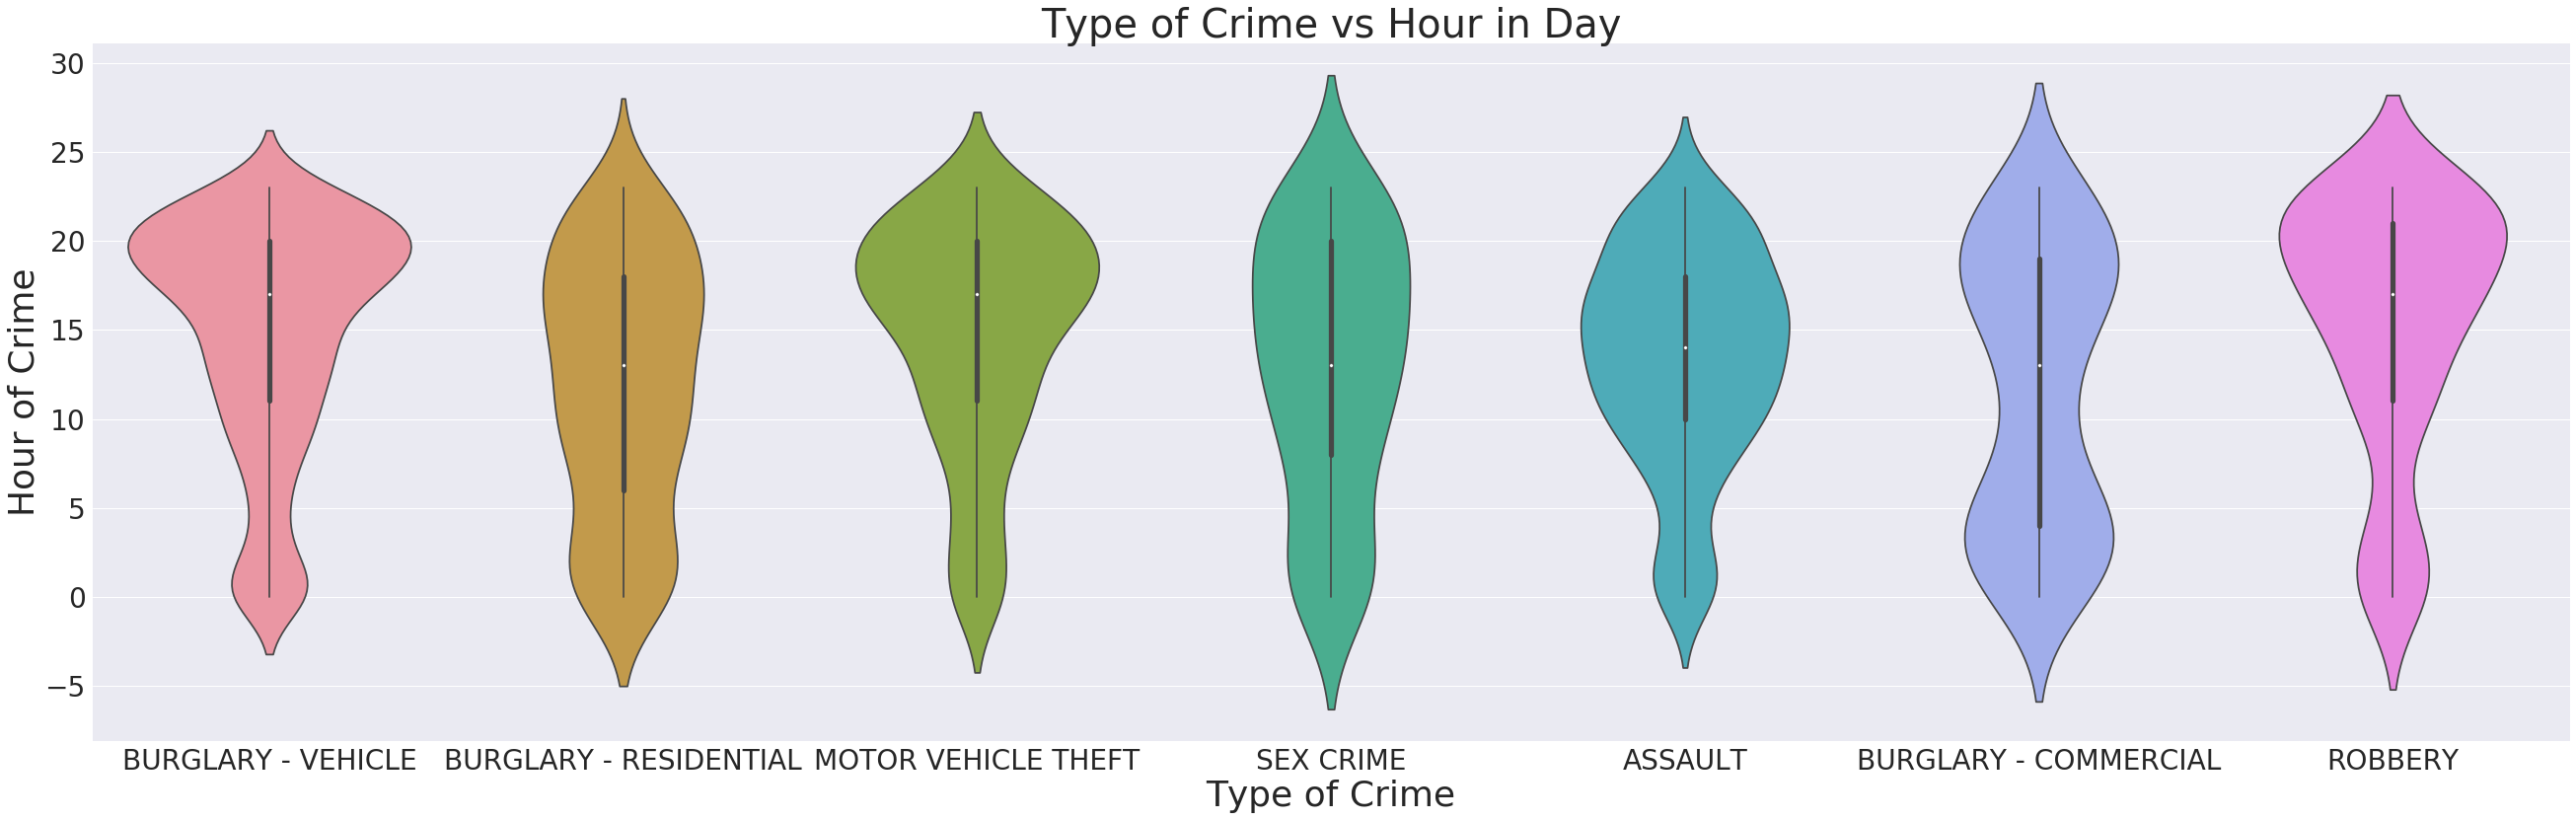

In [718]:
fs = 28
plots = plt.subplots(1, 1, figsize=(45,13))
plot_violin= sns.violinplot(x=bpd_lim['CVLEGEND'], y=bpd_lim['Hour'], width=0.8)
plot_violin.set_xlabel("Type of Crime",fontsize=fs+8)
plot_violin.set_ylabel("Hour of Crime",fontsize=fs+8)


plot_violin.tick_params(labelsize=fs)
plot_violin.set_title('Type of Crime vs Hour in Day', fontsize=fs+12)

### Conclusion : while crimes overall are equally likely to appear any hour of the day, the distributions of individual crimes are not uniform.

# Distribution of crimes across day of the week

In [500]:
""" Convert days (datetime) to integers that represent day of the week """

# bpd['Day of week'] = bpd[['EVENTDT']].datetime.weekday_name
bpd_lim['Day of week'] = bpd_lim['EVENTDT'].apply(lambda x: x.weekday())
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# bpd[['EVENTDT']].values[0][0].weekday()

/home/fztso1/IzODA/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [501]:
bpd_lim.head()

,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,LatLon,Lat,Lon,TIME_1HR,Hour,Day of week
9,BURGLARY AUTO,2019-10-19,1900-01-01 21:41:00,BURGLARY - VEHICLE,6,11/8/19 7:01,"37.850385, -122.270897",37.850385,-122.270897,21:00:00,21,5
10,BURGLARY AUTO,2019-09-10,1900-01-01 15:00:00,BURGLARY - VEHICLE,2,11/8/19 7:01,"37.868663, -122.301325",37.868663,-122.301325,15:00:00,15,1
12,BURGLARY RESIDENTIAL,2019-07-10,1900-01-01 02:00:00,BURGLARY - RESIDENTIAL,3,11/8/19 7:01,"37.868199, -122.263253",37.868199,-122.263253,02:00:00,2,2
17,VEHICLE STOLEN,2019-08-06,1900-01-01 14:30:00,MOTOR VEHICLE THEFT,2,11/8/19 7:01,"37.887961, -122.269822",37.887961,-122.269822,14:00:00,14,1
19,SEXUAL ASSAULT MISD.,2019-06-22,1900-01-01 13:15:00,SEX CRIME,6,11/8/19 7:01,"37.865134, -122.258331",37.865134,-122.258331,13:00:00,13,5


In [502]:
num_crimes_day = bpd_lim.groupby('Day of week').count().iloc[:,0].values

In [503]:
num_crimes_day

array([358, 288, 331, 341, 335, 322, 304])

/home/fztso1/IzODA/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


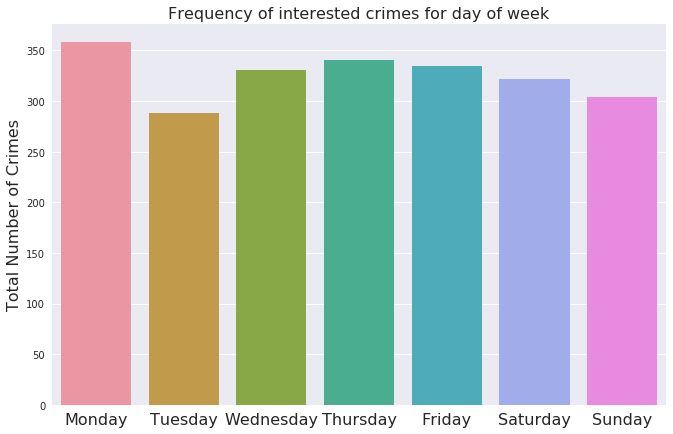

In [725]:
fs2 = 16
plots = plt.subplots(1, 1, figsize=(11, 7))
plot_day = sns.barplot(x=days_of_week, y=num_crimes_day)
plot_day.set_xticklabels(days_of_week, fontsize=fs2)
plot_day.set_ylabel('Total Number of Crimes', fontsize=fs2)
plot_day.set_title('Frequency of interested crimes for day of week', fontsize=fs2)

In [504]:
bpd_lim.groupby('CVLEGEND').count()

,OFFENSE,EVENTDT,EVENTTM,CVDOW,InDbDate,LatLon,Lat,Lon,TIME_1HR,Hour,Day of week
CVLEGEND,,,,,,,,,,,
ASSAULT,270,270,270,270,270,270,270,270,270,270,270
BURGLARY - COMMERCIAL,136,136,136,136,136,136,136,136,136,136,136
BURGLARY - RESIDENTIAL,183,183,183,183,183,183,183,183,183,183,183
BURGLARY - VEHICLE,1198,1198,1198,1198,1198,1198,1198,1198,1198,1198,1198
MOTOR VEHICLE THEFT,254,254,254,254,254,254,254,254,254,254,254
ROBBERY,169,169,169,169,169,169,169,169,169,169,169
SEX CRIME,69,69,69,69,69,69,69,69,69,69,69


In [505]:
crimes_lim_2 = ['ASSAULT', 'BURGLARY', 'MOTOR VEHICLE THEFT', 'ROBBERY', 'SEX CRIME']
def group_burglaries(s):
    if s[0] == 'B':
        return 'BURGLARY'
    else:
        return s
# group the burglary ones together
bpd_lim['CVLEGEND_2'] = bpd_lim['CVLEGEND'].apply(group_burglaries)
# bpd_lim.head()
# bpd_lim_2 = bpd_lim.groupby(['Day of week', 'CVLEGEND_2']).count()[['OFFENSE']].rename(columns={'OFFENSE' : 'COUNT'})
# bpd_lim_2.index

/home/fztso1/IzODA/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [506]:
bpd_lim = bpd_lim.rename(columns={"Day of week": "DOW"})

In [581]:
a = [1, 2, 3]
a[:-1]

[1, 2]

In [633]:
day_crime = pd.crosstab(bpd_lim['DOW'], bpd_lim['CVLEGEND_2'], normalize='columns')
day_crime['DOW'] = day_crime.index
# day_crime_long = pd.melt(day_crime,id_vars="DOW",var_name='CVLEGEND_2', value_name='mean')
day_crime = day_crime.iloc[:, :-1]
day_crime
# plt.figure(figsize=(20, 15))
# sns.relplot(x="Day of the week", y="counts", hue="CVLEGEND_2",
#                 size=10, aspect=1.5, facet_kws=dict(sharex=True),
#                 kind="line", legend="full", data=day_crime_long)
# plt.xlabel('Day of the week')
# plt.ylabel('Number of calls')

CVLEGEND_2,ASSAULT,BURGLARY,MOTOR VEHICLE THEFT,ROBBERY,SEX CRIME
DOW,,,,,
0,0.133333,0.170732,0.129921,0.171598,0.014493
1,0.114815,0.122610,0.129921,0.153846,0.173913
2,0.133333,0.152933,0.145669,0.106509,0.115942
3,0.122222,0.143705,0.185039,0.189349,0.159420
4,0.174074,0.141068,0.133858,0.130178,0.260870
5,0.155556,0.133158,0.165354,0.136095,0.188406
6,0.166667,0.135794,0.110236,0.112426,0.086957


/home/fztso1/IzODA/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


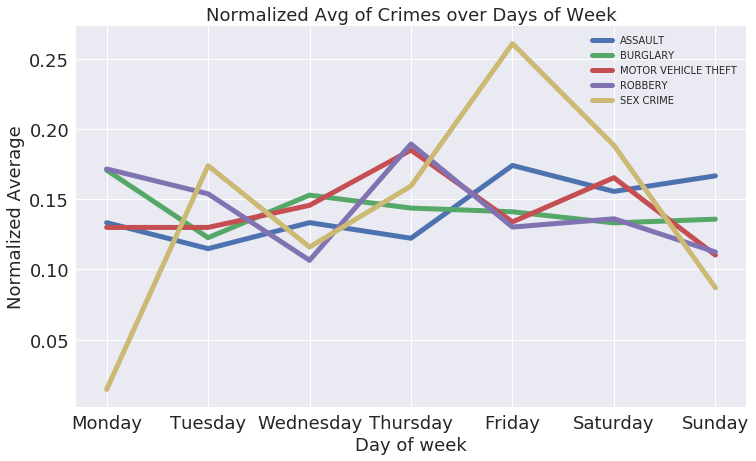

In [728]:
fig = plt.figure(figsize=(12, 7))
ax = plt.axes()
fs = 18
plt.setp(ax.get_xticklabels(), fontsize=fs)
plt.setp(ax.get_yticklabels(), fontsize=fs)

x = np.arange(7)
for i in np.arange(5):
    ax.plot(x, day_crime.iloc[:,i].values, lw=5.0, label=crimes_lim_2[i])
plt.legend()
plt.xlabel('Day of week', fontsize=fs)
plt.xticks(x, days_of_week)
plt.ylabel('Normalized Average', fontsize=fs)
plt.title('Normalized Avg of Crimes over Days of Week',fontsize=fs)

## Area code stats

In [510]:
bpd_lim

,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,LatLon,Lat,Lon,TIME_1HR,Hour,DOW,CVLEGEND_2
9,BURGLARY AUTO,2019-10-19,1900-01-01 21:41:00,BURGLARY - VEHICLE,6,11/8/19 7:01,"37.850385, -122.270897",37.850385,-122.270897,21:00:00,21,5,BURGLARY
10,BURGLARY AUTO,2019-09-10,1900-01-01 15:00:00,BURGLARY - VEHICLE,2,11/8/19 7:01,"37.868663, -122.301325",37.868663,-122.301325,15:00:00,15,1,BURGLARY
12,BURGLARY RESIDENTIAL,2019-07-10,1900-01-01 02:00:00,BURGLARY - RESIDENTIAL,3,11/8/19 7:01,"37.868199, -122.263253",37.868199,-122.263253,02:00:00,2,2,BURGLARY
17,VEHICLE STOLEN,2019-08-06,1900-01-01 14:30:00,MOTOR VEHICLE THEFT,2,11/8/19 7:01,"37.887961, -122.269822",37.887961,-122.269822,14:00:00,14,1,MOTOR VEHICLE THEFT
19,SEXUAL ASSAULT MISD.,2019-06-22,1900-01-01 13:15:00,SEX CRIME,6,11/8/19 7:01,"37.865134, -122.258331",37.865134,-122.258331,13:00:00,13,5,SEX CRIME
20,BURGLARY AUTO,2019-06-22,1900-01-01 05:20:00,BURGLARY - VEHICLE,6,11/8/19 7:01,"37.867209, -122.256554",37.867209,-122.256554,05:00:00,5,5,BURGLARY
22,BURGLARY AUTO,2019-08-30,1900-01-01 10:30:00,BURGLARY - VEHICLE,5,11/8/19 7:01,"37.882217, -122.302226",37.882217,-122.302226,10:00:00,10,4,BURGLARY
24,BURGLARY AUTO,2019-10-17,1900-01-01 00:30:00,BURGLARY - VEHICLE,4,11/8/19 7:01,"37.865511, -122.309967",37.865511,-122.309967,00:00:00,0,3,BURGLARY
25,BURGLARY AUTO,2019-06-14,1900-01-01 14:30:00,BURGLARY - VEHICLE,5,11/8/19 7:01,"37.847281, -122.27545",37.847281,-122.275450,14:00:00,14,4,BURGLARY
27,BURGLARY AUTO,2019-05-20,1900-01-01 11:00:00,BURGLARY - VEHICLE,1,11/8/19 7:01,"37.87142, -122.303532",37.871420,-122.303532,11:00:00,11,0,BURGLARY


In [516]:
# get lat/long coordinates
# you can skip the Point section if you're not mapping!!
combined = bpd_lim
for i in combined.index:
#     combined.loc[i,'LatLon'] = combined.loc[i,'Block_Location'][combined.loc[i,'Block_Location'].find("(")+1:combined.loc[i,'Block_Location'].rfind(")")]
    combined.loc[i,'Lat'] = float(combined.loc[i,'LatLon'][0:combined.loc[i,'LatLon'].find(',')])
    combined.loc[i,'Lon'] = float(combined.loc[i,'LatLon'][combined.loc[i,'LatLon'].find(',')+2:])
    
combined = combined.drop(combined.columns[[0, 1, 2, 3, 4, 5, 6]], axis=1)
# geometry = [Point(xy) for xy in zip(combined['Lon'], combined['Lat'])]
# combined['geometry'] = geometry
# combined_gpd = gpd.GeoDataFrame(combined)

In [517]:
combined.head()

,Lat,Lon,TIME_1HR,Hour,DOW,CVLEGEND_2
9,37.850385,-122.270897,21:00:00,21,5,BURGLARY
10,37.868663,-122.301325,15:00:00,15,1,BURGLARY
12,37.868199,-122.263253,02:00:00,2,2,BURGLARY
17,37.887961,-122.269822,14:00:00,14,1,MOTOR VEHICLE THEFT
19,37.865134,-122.258331,13:00:00,13,5,SEX CRIME


In [518]:
min_lon = -122.3248898948758
max_lon = -122.2341693306841
min_lat = 37.84588599818213
max_lat = 37.90584136967829

# with 10 divisions used!!
lat_divisions = [37.84588599818213,
 37.85188153533175,
 37.857877072481365,
 37.86387260963098,
 37.8698681467806,
 37.87586368393021,
 37.88185922107983,
 37.887854758229444,
 37.89385029537906,
 37.899845832528676,
 37.90584136967829]

lon_divisions = [-122.3248898948758,
 -122.31581783845662,
 -122.30674578203745,
 -122.29767372561828,
 -122.28860166919911,
 -122.27952961277995,
 -122.27045755636078,
 -122.26138549994161,
 -122.25231344352244,
 -122.24324138710327,
 -122.2341693306841]

## Code for divisions

In [519]:
divisions = 10
for i in combined.index:
    # Assigning the appropriate ('box')
    lat_val = combined.loc[i,'Lat']
    lon_val = combined.loc[i,'Lon']
    for j in np.arange(len(lat_divisions)-1)+1:
        if lat_val / lat_divisions[j] < 1:
            row_num = j
            break
    for j in np.arange(len(lon_divisions)-1)+1:
        if lon_val / lon_divisions[j] > 1:
            col_num = j
            break
    combined.loc[i,'BOXNUM'] = divisions*(row_num-1) + col_num
combined['BOXNUM'] = combined['BOXNUM'].astype(int)

In [520]:
combined.head()

,Lat,Lon,TIME_1HR,Hour,DOW,CVLEGEND_2,BOXNUM
9,37.850385,-122.270897,21:00:00,21,5,BURGLARY,6
10,37.868663,-122.301325,15:00:00,15,1,BURGLARY,33
12,37.868199,-122.263253,02:00:00,2,2,BURGLARY,37
17,37.887961,-122.269822,14:00:00,14,1,MOTOR VEHICLE THEFT,77
19,37.865134,-122.258331,13:00:00,13,5,SEX CRIME,38


In [559]:
bpd_boxes_all = combined.groupby(['BOXNUM']).count()
bpd_boxes_all = bpd_boxes_all.iloc[:, [0]]
bpd_boxes_all = bpd_boxes_all.rename(columns={'Lat':'COUNT'})
bpd_boxes_all['COUNT'] = bpd_boxes_all['COUNT'].sort_values(ascending=False).values
bpd_boxes_all.head()

,COUNT
BOXNUM,
4,218
5,181
6,128
8,115
9,93


In [564]:
bpd_boxes = combined.groupby(['BOXNUM', 'CVLEGEND_2']).count().iloc[:, [0]].rename(columns={'Lat':'COUNT'})

In [566]:
bpd_boxes.head(10)

COUNT
BOXNUM CVLEGEND_2                
4      BURGLARY                20
       MOTOR VEHICLE THEFT      3
5      BURGLARY                 8
       MOTOR VEHICLE THEFT      6
6      ASSAULT                 11
       BURGLARY                26
       MOTOR VEHICLE THEFT     10
       ROBBERY                 10
       SEX CRIME                2
8      BURGLARY                 3

### KNN Classifier

In [682]:
bpd_lim['MO'] = bpd['EVENTDT'].apply(lambda x: int(x.month))
bpd_lim

,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,LatLon,Lat,Lon,TIME_1HR,Hour,DOW,CVLEGEND_2,MO
9,BURGLARY AUTO,2019-10-19,1900-01-01 21:41:00,BURGLARY - VEHICLE,6,11/8/19 7:01,"37.850385, -122.270897",37.850385,-122.270897,21:00:00,21,5,BURGLARY,10
10,BURGLARY AUTO,2019-09-10,1900-01-01 15:00:00,BURGLARY - VEHICLE,2,11/8/19 7:01,"37.868663, -122.301325",37.868663,-122.301325,15:00:00,15,1,BURGLARY,9
12,BURGLARY RESIDENTIAL,2019-07-10,1900-01-01 02:00:00,BURGLARY - RESIDENTIAL,3,11/8/19 7:01,"37.868199, -122.263253",37.868199,-122.263253,02:00:00,2,2,BURGLARY,7
17,VEHICLE STOLEN,2019-08-06,1900-01-01 14:30:00,MOTOR VEHICLE THEFT,2,11/8/19 7:01,"37.887961, -122.269822",37.887961,-122.269822,14:00:00,14,1,MOTOR VEHICLE THEFT,8
19,SEXUAL ASSAULT MISD.,2019-06-22,1900-01-01 13:15:00,SEX CRIME,6,11/8/19 7:01,"37.865134, -122.258331",37.865134,-122.258331,13:00:00,13,5,SEX CRIME,6
20,BURGLARY AUTO,2019-06-22,1900-01-01 05:20:00,BURGLARY - VEHICLE,6,11/8/19 7:01,"37.867209, -122.256554",37.867209,-122.256554,05:00:00,5,5,BURGLARY,6
22,BURGLARY AUTO,2019-08-30,1900-01-01 10:30:00,BURGLARY - VEHICLE,5,11/8/19 7:01,"37.882217, -122.302226",37.882217,-122.302226,10:00:00,10,4,BURGLARY,8
24,BURGLARY AUTO,2019-10-17,1900-01-01 00:30:00,BURGLARY - VEHICLE,4,11/8/19 7:01,"37.865511, -122.309967",37.865511,-122.309967,00:00:00,0,3,BURGLARY,10
25,BURGLARY AUTO,2019-06-14,1900-01-01 14:30:00,BURGLARY - VEHICLE,5,11/8/19 7:01,"37.847281, -122.27545",37.847281,-122.275450,14:00:00,14,4,BURGLARY,6
27,BURGLARY AUTO,2019-05-20,1900-01-01 11:00:00,BURGLARY - VEHICLE,1,11/8/19 7:01,"37.87142, -122.303532",37.871420,-122.303532,11:00:00,11,0,BURGLARY,5


In [683]:
sklearn.__version__

'0.18.1'

In [685]:
X = np.vstack((bpd_lim.loc[:, 'Lat'].values, 
               bpd_lim.loc[:, 'Lon'].values, 
               bpd_lim.loc[:, 'Hour'].values, 
               bpd_lim.loc[:, 'DOW'].values,
               bpd_lim.loc[:, 'MO'].values)).T
y = bpd_lim.loc[:, 'CVLEGEND_2'].values

In [686]:
from sklearn.neighbors import KNeighborsClassifier

In [687]:
k = 5
neigh = KNeighborsClassifier(n_neighbors=k)
neigh.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [692]:
neigh.predict([37.872545, -122.298043, 0, 1, 10])

/home/fztso1/IzODA/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array(['BURGLARY'], dtype=object)